In [5]:
# Importação das bibliotecas necessárias
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights
from time import time

# Definição do caminho dos dados de treino e teste
# Dependendo do flag False, o caminho dos dados será alterado para 'cats_vs_dogs' ou 'myImageNet'
if False:
    train_data_path = 'data/train_data_myImageNet_224.npy'
    train_labels_path = 'data/train_labels_myImageNet_224.npy'
    test_data_path = 'data/test_data_myImageNet_224.npy'
    test_labels_path = 'data/test_labels_myImageNet_224.npy'
else:
    train_data_path = 'data/train_data_cats_vs_dogs_224.npy'
    train_labels_path = 'data/train_labels_cats_vs_dogs_224.npy'
    test_data_path = 'data/test_data_cats_vs_dogs_224.npy'
    test_labels_path = 'data/test_labels_cats_vs_dogs_224.npy'

# Definição de uma semente para garantir resultados determinísticos
SEED = 666

# Função para definir as sementes e tornar o código mais determinístico
def determinize(SEED: int):
    """
    Define as sementes para as bibliotecas PyTorch e NumPy, garantindo que as execuções sejam determinísticas.

    Esta função ajusta as sementes para a geração de números aleatórios no PyTorch (tanto para CPU quanto para GPU) 
    e no NumPy, além de forçar o PyTorch a usar algoritmos determinísticos.

    Args:
        SEED (int): O valor da semente para controle da aleatoriedade.

    """
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    torch.use_deterministic_algorithms(True)

# Chama a função de determinização com a semente definida
determinize(SEED)

# Verifica se há uma GPU disponível e seleciona o dispositivo apropriado
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Importando e pré-processando os dados

In [6]:
class ColorizationDataset(Dataset):
    """
    Dataset para tarefa de colorização de imagens, onde a entrada é uma imagem em escala de cinza e a saída é a imagem colorida correspondente.

    O dataset assume que as imagens em escala de cinza e coloridas estão armazenadas em arquivos `.npy` como arrays NumPy. 
    As imagens são carregadas de maneira eficiente utilizando `mmap_mode`, para evitar o carregamento completo na memória.
    
    Args:
        gray_path (str): Caminho para o arquivo `.npy` contendo as imagens em escala de cinza.
        color_path (str): Caminho para o arquivo `.npy` contendo as imagens coloridas.
        transform (callable, opcional): Função de transformação para ser aplicada nas imagens.
    
    """
    
    def __init__(self, gray_path, color_path, transform=None):
        """
        Inicializa o dataset com os caminhos para as imagens em escala de cinza e coloridas.

        Args:
            gray_path (str): Caminho para o arquivo `.npy` contendo as imagens em escala de cinza.
            color_path (str): Caminho para o arquivo `.npy` contendo as imagens coloridas.
            transform (callable, opcional): Função de transformação para ser aplicada nas imagens.
        """
        # Carrega os arrays uint8 do disco (sem carregar na RAM)
        self.grayscale = np.load(gray_path, mmap_mode='r')  # Shape (N, 224, 224)
        self.color = np.load(color_path, mmap_mode='r')     # Shape (N, 224, 224, 3)
        self.transform = transform

    def __len__(self) -> int:
        """
            Retorna o número total de amostras no dataset.

            Returns:
                int: O número de amostras (imagens) no dataset.
        """
        return len(self.grayscale)

    def __getitem__(self, idx):
        """
        Obtém uma amostra do dataset dada uma posição `idx`.

        Carrega as imagens em escala de cinza e coloridas, realiza a conversão para `float32`, 
        ajusta as dimensões para (C, H, W) e normaliza as imagens para o intervalo [-1, 1]. 
        Caso uma transformação seja fornecida, ela será aplicada nas imagens.

        Args:
            idx (int): Índice da amostra a ser retornada.

        Returns:
            tuple: Uma tupla contendo a imagem em escala de cinza e a imagem colorida correspondente, ambas normalizadas.
                    (gray, color) com forma (3, 224, 224) para `gray` e (3, 224, 224) para `color`.
        """
        # Carrega os dados uint8 e converte para float32
        gray = self.grayscale[idx].astype(np.float32)  # Shape (224, 224)
        color = self.color[idx].astype(np.float32)     # Shape (224, 224, 3)

        # Converte para tensor e ajusta dimensões (C, H, W)
        gray = torch.from_numpy(gray)  # (224, 224)
        color = torch.from_numpy(color).permute(2, 0, 1) # (3, 224, 224)

        # Ajusta o gray para 3 canais idênticos
        gray = torch.stack([gray.clone() for _ in range(3)], dim=0)  # Canais independentes

        # Normaliza para [-1, 1]
        gray = (gray / 127.5) - 1.0
        color = (color / 127.5) - 1.0

        if self.transform:
            # Aplica transformações
            # Empilha para aplicar a mesma transformação em gray e color
            stacked = torch.cat([gray, color], dim=0)    # (6, 224, 224)
            stacked = self.transform(stacked)
            gray, color = torch.split(stacked, [3, 3], dim=0)

        return gray, color

In [7]:
def construct_dataloaders(batch_size) -> tuple[DataLoader]:
    """
    Constrói os dataloaders para os conjuntos de treino e teste a partir dos datasets de colorização.

    Essa função carrega os dados de treino e teste usando a classe `ColorizationDataset`, cria `DataLoader`s
    para ambos os conjuntos, e retorna esses dataloaders para uso posterior no treinamento e avaliação do modelo.

    Args:
        batch_size (int): O tamanho do batch para os dataloaders. Define o número de amostras que serão processadas em cada iteração.

    Returns:
        tuple[DataLoader]: Uma tupla contendo:
            - `train_dataloader` (DataLoader): O dataloader para o conjunto de treino.
            - `test_dataloader` (DataLoader): O dataloader para o conjunto de teste.
    """
    
    # Criação do dataset de treino com o caminho dos dados e rótulos
    train_dataset = ColorizationDataset(
        gray_path=train_data_path,
        color_path=train_labels_path,
        # transform=train_transform
    )

    # Criação do dataloader para o conjunto de treino
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True      # Otimiza a transferência para GPU
    )

    # Libera o dataset de treino da memória após a criação do dataloader
    del train_dataset

    # Criação do dataset de teste com o caminho dos dados e rótulos
    test_dataset = ColorizationDataset(
        gray_path=test_data_path,
        color_path=test_labels_path,
    )

    # Criação do dataloader para o conjunto de teste
    test_dataloader  = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True      # Otimiza a transferência para GPU
    )

    # Libera o dataset de teste da memória após a criação do dataloader
    del test_dataset

    # Retorna os dataloaders de treino e teste
    return train_dataloader, test_dataloader

In [8]:
# from torchvision import transforms
# # Data agumentation (se necessário)
# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(10),
#     # Adicione outras transformações conforme necessário
# ])

### Definindo o modelo

In [9]:
class ResNet18Encoder(nn.Module):
    """
    Implementação de um encoder baseado na arquitetura ResNet-18. O modelo utiliza uma versão pré-treinada do ResNet-18,
    congelando seus parâmetros para não realizar treinamento durante a utilização do encoder. O objetivo é extrair
    características de diferentes níveis de resolução a partir das imagens de entrada.

    O ResNet-18 é uma rede residual com 18 camadas que foi previamente treinada no ImageNet. As camadas do encoder 
    extraem características da imagem em diferentes resoluções.

    A arquitetura de saída do encoder retorna uma série de "skip connections" (x0, x2, x3, x4, x5), representando
    diferentes estágios de processamento da rede.

    A saída da rede é projetada para ser usada em tarefas como redes de colorização ou outras redes que possam
    se beneficiar de múltiplas resoluções de características.

    Atributes:
        conv1 (nn.Conv2d): Primeira camada convolucional da ResNet.
        bn1 (nn.BatchNorm2d): Primeira camada de normalização em batch.
        relu (nn.ReLU): Função de ativação ReLU.
        maxpool (nn.MaxPool2d): Camada de max pooling para redução de resolução.
        layer1 (nn.Sequential): Camada de blocos residuais 1.
        layer2 (nn.Sequential): Camada de blocos residuais 2.
        layer3 (nn.Sequential): Camada de blocos residuais 3.
        layer4 (nn.Sequential): Camada de blocos residuais 4.
    """
    
    def __init__(self):
        """
        Inicializa o encoder ResNet-18. Carrega o modelo ResNet-18 pré-treinado e congela seus parâmetros.
        As camadas do modelo são extraídas e preparadas para uso no encoder.

        A rede utiliza um modelo pré-treinado para não treinar novamente os pesos das camadas do ResNet-18, 
        e sim para extrair as características das imagens.
        """
        super().__init__()
        
        # Carrega o modelo ResNet-18 pré-treinado
        resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)  
        
        # Congela os parâmetros do ResNet para evitar atualização
        for param in resnet.parameters():
            param.requires_grad = False  

        # Camadas do encoder (extraídas do modelo ResNet-18)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        self.layer1 = resnet.layer1  # Saída: 64x56x56
        self.layer2 = resnet.layer2  # Saída: 128x28x28
        self.layer3 = resnet.layer3  # Saída: 256x14x14
        self.layer4 = resnet.layer4  # Saída: 512x7x7

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Realiza a passagem direta (forward pass) do modelo. Aplica as camadas do encoder e coleta as saídas das
        camadas intermediárias, retornando uma série de "skip connections" que representam diferentes resoluções
        da imagem original.

        Args:
            x (Tensor): Entrada da rede (normalmente uma imagem de tamanho (B, 3, 224, 224)).

        Returns:
            tuple[Tensor]: Uma tupla contendo as saídas de diferentes camadas da rede:
                - x0 (Tensor): Saída da camada convolucional inicial (64x56x56)
                - x2 (Tensor): Saída da segunda camada residual (64x56x56)
                - x3 (Tensor): Saída da terceira camada residual (128x28x28)
                - x4 (Tensor): Saída da quarta camada residual (256x14x14)
                - x5 (Tensor): Saída da última camada residual (512x7x7)
        """
        # Forward pass e coleta de skips
        x0 = self.relu(self.bn1(self.conv1(x)))  # 64x112x112 (stride 2)
        x1 = self.maxpool(x0)                    # 64x56x56
        
        x2 = self.layer1(x1)  # 64x56x56
        x3 = self.layer2(x2)  # 128x28x28
        x4 = self.layer3(x3)  # 256x14x14
        x5 = self.layer4(x4)  # 512x7x7
        
        return x0, x2, x3, x4, x5

In [10]:
class DecoderBlock(nn.Module):
    """
    Bloco de decodificação utilizado para aumentar a resolução das imagens e combinar características extraídas 
    com as "skip connections" do encoder. Realiza upsampling, concatenando as características da camada anterior 
    com as características correspondentes do encoder, e aplica convoluções seguidas de normalização e funções de 
    ativação.

    O `DecoderBlock` é comumente utilizado em redes neurais do tipo "autoencoder" ou em tarefas de 
    segmentação semântica, onde a rede precisa aprender a reconstruir a imagem a partir de uma representação compacta.
    
    Args:
        in_channels (int): Número de canais de entrada.
        out_channels (int): Número de canais de saída.
        skip_channels (int): Número de canais da "skip connection".
        dropout_rate (float, opcional): Taxa de dropout para regularização.
    """
    
    def __init__(self, in_channels, out_channels, skip_channels, dropout_rate=0.2):
        """
        Inicializa o bloco de decodificação com uma camada de upsampling, seguida por convoluções, normalização em batch, 
        ativação ReLU e regularização via dropout.

        Args:
            in_channels (int): Número de canais de entrada.
            out_channels (int): Número de canais de saída.
            skip_channels (int): Número de canais da "skip connection".
            dropout_rate (float, opcional): Taxa de dropout para regularização.
        """
        super().__init__()

        # Upsampling: ConvTranspose2d aumenta a resolução da imagem
        self.up = nn.ConvTranspose2d(
            in_channels, out_channels, 
            kernel_size=3, stride=2, 
            padding=1, output_padding=1
        )

        # Convoluções e operações subsequentes para combinar as características do upsampling com a "skip connection"
        self.conv = nn.Sequential(
            nn.Dropout(p=dropout_rate),  # Dropout para regularização
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Normalização em batch
            nn.ReLU(inplace=True),  # Função de ativação ReLU
            nn.Dropout(p=dropout_rate),  # Dropout para regularização
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Normalização em batch
            nn.ReLU(inplace=True)  # Função de ativação ReLU
        )

    def forward(self, x, skip):
        """
        Realiza a passagem direta (forward pass) do bloco de decodificação.

        O método aplica a operação de upsampling (convTranspose2d) para aumentar a resolução da entrada `x`, 
        concatena com a "skip connection" `skip`, e aplica as convoluções subsequentes para produzir a saída.

        Args:
            x (Tensor): Tensor de entrada com características da camada anterior.
            skip (Tensor): Tensor da "skip connection" com características da camada correspondente do encoder.

        Returns:
            Tensor: A saída resultante após upsampling, concatenação e convoluções.
        """
        x = self.up(x)  # Aplica upsampling
        x = torch.cat([x, skip], dim=1)  # Concatena a saída com a "skip connection"
        x = self.conv(x)  # Aplica as convoluções e operações subsequentes
        return x

In [11]:
class UResNet50(nn.Module):
    """
    Classe para o modelo U-ResNet50, um modelo de rede neural convolucional baseado na arquitetura U-Net 
    com ResNet18 como encoder. Este modelo é projetado para realizar tarefas de colorização de imagens 
    em que a entrada é uma imagem em escala de cinza e a saída é uma imagem colorida.

    A rede é composta por um encoder (ResNet18) seguido por vários blocos de decodificação (DecoderBlock) 
    para aumentar a resolução da imagem, restaurando detalhes perdidos na compressão.

    A rede usa a função de perda MSE (Mean Squared Error) e calcula o PSNR (Peak Signal-to-Noise Ratio) 
    para avaliar a qualidade das predições.

    A classe também implementa métodos para treinamento, validação, ajuste de taxa de aprendizado, 
    e salvamento de histórico durante o processo de treinamento.

    Atributes:
        encoder (ResNet18Encoder): Encoder baseado em ResNet18.
        decoder4, decoder3, decoder2, decoder1 (DecoderBlock): Blocos de decodificação para aumentar a resolução da imagem.
        final_upsample (nn.Sequential): Camada final de upsampling para gerar a imagem colorida de saída com 224x224 pixels.
        optimizer (torch.optim.Adam): Otimizador Adam para otimização do modelo.
        scheduler (torch.optim.lr_scheduler.ReduceLROnPlateau): Scheduler para ajuste de taxa de aprendizado.
        device (torch.device): Dispositivo utilizado para treinamento (GPU ou CPU).
    """


    def __init__(self):
        """
        Inicializa a arquitetura U-ResNet50 com encoder ResNet18, blocos de decodificação e camada final de upsampling.
        Também configura o otimizador, o scheduler de aprendizado e o dispositivo (GPU ou CPU).
        """
        super().__init__()
        self.encoder = ResNet18Encoder()
        
        # Blocos do decoder (in_channels, out_channels, skip_channels)
        self.decoder4 = DecoderBlock(512, 256, 256)  # 7x7 → 14x14
        self.decoder3 = DecoderBlock(256, 128, 128)  # 14x14 → 28x28
        self.decoder2 = DecoderBlock(128, 64, 64)    # 28x28 → 56x56
        self.decoder1 = DecoderBlock(64, 64, 64)     # 56x56 → 112x112 (usa skip x0)
        
        # Camada final para 224x224
        self.final_upsample = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=1),  # Saída RGB
            nn.Sigmoid()
        )
        
        self._curr_epoch = 0
        
        # Otimizador
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0002)

        # Definindo o scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.8, patience=5
        )
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        print(f"Modelo instanciado em: {self.device}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Realiza a passagem direta (forward pass) do modelo, aplicando o encoder seguido pelos blocos de decodificação 
        e a camada final de upsampling para gerar a imagem colorida de saída.

        Args:
            x (Tensor): Tensor de entrada com a imagem em escala de cinza (tamanho N x 1 x 224 x 224).

        Retorns:
            Tensor: A imagem colorida de saída (tamanho N x 3 x 224 x 224).
        """
        # Encoder
        s0, s1, s2, s3, s4 = self.encoder(x)
        
        # Decoder
        d4 = self.decoder4(s4, s3)  # 14x14
        d3 = self.decoder3(d4, s2)  # 28x28
        d2 = self.decoder2(d3, s1)  # 56x56
        d1 = self.decoder1(d2, s0)  # 112x112
        
        # Saída final
        out = self.final_upsample(d1)  # 224x224
        return out
    
    def PSNR(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Calcula o Peak Signal-to-Noise Ratio (PSNR) entre a predição e o alvo.

        Args:
            pred (Tensor): Tensor de predições do modelo.
            target (Tensor): Tensor de valores reais (verdadeiros).

        Retorns:
            Tensor: O valor do PSNR calculado.
        """
        max_pixel: float = 1.0
        mse = F.mse_loss(pred, target)
        psnr: torch.Tensor = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr
    
    def validate_model(
        self, validation_dataloader: DataLoader, total_validation_samples: int, total_val_batches: int
    ) -> tuple[float]:
        """
        Realiza a validação do modelo em um conjunto de dados de validação, calculando a loss média e o PSNR.

        Args:
            validation_dataloader (DataLoader): DataLoader contendo o conjunto de dados de validação.
            total_validation_samples (int): Número total de amostras no conjunto de validação.
            total_val_batches (int): Número total de batches no conjunto de validação.

        Retorns:
            tuple: A perda média (val_loss) e o PSNR médio (val_psnr) durante a validação.
        """
        # Variáveis acumuladoras
        val_loss: float = 0.0
        val_psnr: float = 0.0

        # Mostra o progresso atual
        print(f"\rEpoch {self._curr_epoch} | Validation batch: 0 of {total_val_batches} | Time: {self.init_time} s", end=f'{' ' * 30}')

        # Coloca o modelo no modo de predição
        self.eval()
        with torch.inference_mode():
            for batch_idx, (X,y) in enumerate(validation_dataloader,1):
                # Move os dados para o dispositivo correto
                X, y = X.to(self.device), y.to(self.device)
                
                # Número de exemplos no batch
                num_samples = y.size(0)

                # Forward pass
                pred: torch.Tensor = self(X)

                # Acumula a loss ponderada pelo número de exemplos
                loss = F.mse_loss(pred, y)
                val_loss += loss.item() * num_samples

                # Acumula o PSNR ponderado pelo número de exemplos
                psnr = self.PSNR(pred, y)
                val_psnr += psnr.item() * num_samples
                
                # Mostra o progresso atual
                print(f"\rEpoch {self._curr_epoch} | Test batch: {batch_idx} of {total_val_batches} | Time: {time() - self.init_time:.1f} s", end=f'{' ' * 30}')

        # Calcula a média dos valores de loss e PSNR
        val_loss /= total_validation_samples
        val_psnr /= total_validation_samples
        return val_loss, val_psnr
    
    def init_history(self):
        """
        Inicializa o arquivo de histórico para registrar as métricas de cada época durante o treinamento.
        """
        self.history = open(f'history_{self._curr_epoch}.csv','w')
        self.history.write('epoch,train_loss,train_psnr,val_loss,val_psnr\n')
        self.history.flush()
        
    def save_curr_state(self,train_loss: float, train_psnr: float, val_loss: float, val_psnr: float):
        """
        Salva o estado atual do modelo no arquivo de histórico.

        Args:
            train_loss (float): Perda de treino da época atual.
            train_psnr (float): PSNR de treino da época atual.
            val_loss (float): Perda de validação da época atual.
            val_psnr (float): PSNR de validação da época atual.
        """
        self.history.write(f'{self._curr_epoch},{train_loss},{train_psnr},{val_loss},{val_psnr}\n')
        self.history.flush()
        
    def end_history(self):
        """
        Finaliza o registro de histórico e fecha o arquivo.
        """
        self.history.close()
    
    def unfreeze(self):
        """
        Descongela todos os parâmetros do modelo, permitindo que sejam treinados.
        """
        for param in self.parameters():
            param.requires_grad = True    
    
    # Método de treinamento
    def train_model(
        self,
        train_dataloader: DataLoader,
        validation_dataloader: DataLoader,
        max_epochs: int,
        statistics_interval: int = 1,
    ):
        """
        Realiza o treinamento do modelo, passando por várias épocas, calculando as métricas e ajustando o modelo com o otimizador.

        Args:
            train_dataloader (DataLoader): DataLoader contendo o conjunto de dados de treino.
            validation_dataloader (DataLoader): DataLoader contendo o conjunto de dados de validação.
            max_epochs (int): Número máximo de épocas para o treinamento.
            statistics_interval (int, opcional): Intervalo de épocas para exibir as métricas de treinamento.
        """

        self.init_history()

        # Extraindo o número de exemplos de treino e validação
        total_train_samples: int = len(train_dataloader.dataset)
        total_validation_samples: int = len(validation_dataloader.dataset)
        # Obtem o número total de batches
        total_train_batches = len(train_dataloader)
        total_val_batches = len(validation_dataloader)
        
        for _ in range(max_epochs):
            # Salva o tempo inicial da época
            self.init_time = time()

            # Atualiza a época atual
            self._curr_epoch += 1

            # Coloca o modelo no modo de treinamento
            self.train()
            
            # Reinicia as variáveis acumuladoras
            train_loss: float = 0.0
            train_psnr: float = 0.0

            # Mostra o progresso atual
            print(f"\rEpoch {self._curr_epoch} | Train batch: 0 of {total_train_batches} | Time: 0 s", end=f'{' ' * 30}')

            # Para cada batch
            for batch_idx, (X,y) in enumerate(train_dataloader,1):
                # Garante que estão no mesmo dispositivo
                X, y = X.to(self.device), y.to(self.device)
                # Número de exemplos no batch
                num_samples = y.size(0)

                # Forward pass
                pred: torch.Tensor = self(X)

                # Calcula a loss
                loss: torch.Tensor = F.mse_loss(pred, y)
                train_loss += loss.item() * num_samples

                # Calcula o PSNR
                psnr: torch.Tensor = self.PSNR(pred, y)
                train_psnr += psnr.item() * num_samples

                # Optmizer ZeroGrad
                self.optimizer.zero_grad()

                # Loss Backwards
                loss.backward()

                # Optimizer Step
                self.optimizer.step()
                
                # Mostra o progresso atual
                print(f"\rEpoch {self._curr_epoch} | Train batch: {batch_idx} of {total_train_batches} | Time: {time() - self.init_time:.1f} s", end=f'{' ' * 30}')

            # Libera memória
            del X, y, pred, loss, psnr

            # Determina a média da loss e psnr de treino
            train_loss /= total_train_samples
            train_psnr /= total_train_samples

            # Validation
            val_loss, val_psnr = self.validate_model(validation_dataloader, total_validation_samples, total_val_batches)

            # Atualizando o scheduler
            self.scheduler.step(val_loss)

            # Salva o estado atual do modelo
            self.save_curr_state(train_loss, train_psnr, val_loss, val_psnr)

            # A cada intervalo de épocas exibe o estado atual do modelo
            if self._curr_epoch % statistics_interval == 0:
                print(
                    f"\rEpoch: {self._curr_epoch} | Train_loss: {train_loss:.6f} | "
                    f"Train_PSNR: {train_psnr:.6f} dB | Val_loss: {val_loss:.6f} | "
                    f"Val_PSNR: {val_psnr:.6f} dB | Time: {time() - self.init_time:.1f} s"
                )

        self.end_history()

In [12]:
# Testando modelo
# Instanciar o modelo
model = UResNet50()

# Exemplo de entrada (batch_size=4, 3 canais, 224x224)
input = torch.randn(4, 3, 224, 224).to(device)

# Forward pass
output = model(input)  # Shape: (4, 3, 224, 224)
print(output.shape)
del input, output, model

Modelo instanciado em: cuda:0
torch.Size([4, 3, 224, 224])


### Treinando o modelo

In [ ]:
# Função para construir os dataloaders de treino e teste
train_dataloader, test_dataloader = construct_dataloaders(batch_size=32)

# Inicialização do modelo UResNet50
colorization_model = UResNet50()

# Número de épocas para o treinamento
num_epochs = 50

# Treinamento do modelo
colorization_model.train_model(
    train_dataloader=train_dataloader, 
    validation_dataloader=test_dataloader,  
    max_epochs=num_epochs, 
    statistics_interval=1, 
)

Modelo instanciado em: cuda:0
Epoch: 1 | Train_loss: 0.457474 | Train_PSNR: 3.452479 dB | Val_loss: 0.404090 | Val_PSNR: 3.944217 dB | Time: 87.1 s
Epoch: 2 | Train_loss: 0.366400 | Train_PSNR: 4.389602 dB | Val_loss: 0.338539 | Val_PSNR: 4.714547 dB | Time: 87.1 s
Epoch: 3 | Train_loss: 0.318174 | Train_PSNR: 5.001846 dB | Val_loss: 0.299586 | Val_PSNR: 5.246897 dB | Time: 87.2 s
Epoch: 4 | Train_loss: 0.286236 | Train_PSNR: 5.460705 dB | Val_loss: 0.274473 | Val_PSNR: 5.628330 dB | Time: 87.1 s
Epoch: 5 | Train_loss: 0.264418 | Train_PSNR: 5.804503 dB | Val_loss: 0.255403 | Val_PSNR: 5.942372 dB | Time: 87.1 s
Epoch: 6 | Train_loss: 0.249736 | Train_PSNR: 6.052037 dB | Val_loss: 0.244281 | Val_PSNR: 6.136558 dB | Time: 87.3 s
Epoch: 7 | Train_loss: 0.239551 | Train_PSNR: 6.232353 dB | Val_loss: 0.236279 | Val_PSNR: 6.281990 dB | Time: 87.1 s
Epoch: 8 | Train_loss: 0.232247 | Train_PSNR: 6.366488 dB | Val_loss: 0.230870 | Val_PSNR: 6.382993 dB | Time: 87.1 s
Epoch: 9 | Train_loss: 0.2

In [ ]:
# Salvando o estado atual do modelo
torch.save(colorization_model.state_dict(), "resnet18_model_v2_150e.pth")

In [ ]:
# Número de épocas para o treinamento
num_epochs = 50

# Função para construir os dataloaders de treino e teste
train_dataloader, test_dataloader = construct_dataloaders(batch_size=8)

# Treinamento do modelo
colorization_model.train_model(
    train_dataloader=train_dataloader, 
    validation_dataloader=test_dataloader,  
    max_epochs=num_epochs, 
    statistics_interval=1, 
)

Epoch: 51 | Train_loss: 0.210096 | Train_PSNR: 6.877062 dB | Val_loss: 0.212714 | Val_PSNR: 6.804145 dB | Time: 105.5 s
Epoch: 52 | Train_loss: 0.207433 | Train_PSNR: 6.934142 dB | Val_loss: 0.212136 | Val_PSNR: 6.817256 dB | Time: 105.8 s
Epoch: 53 | Train_loss: 0.206129 | Train_PSNR: 6.962517 dB | Val_loss: 0.211627 | Val_PSNR: 6.828361 dB | Time: 105.4 s
Epoch: 54 | Train_loss: 0.205443 | Train_PSNR: 6.977515 dB | Val_loss: 0.211632 | Val_PSNR: 6.828012 dB | Time: 105.2 s
Epoch: 55 | Train_loss: 0.205210 | Train_PSNR: 6.982637 dB | Val_loss: 0.211157 | Val_PSNR: 6.838242 dB | Time: 130.8 s
Epoch: 56 | Train_loss: 0.205160 | Train_PSNR: 6.983999 dB | Val_loss: 0.211502 | Val_PSNR: 6.830651 dB | Time: 105.3 s
Epoch: 57 | Train_loss: 0.204760 | Train_PSNR: 6.992814 dB | Val_loss: 0.211081 | Val_PSNR: 6.840218 dB | Time: 105.5 s
Epoch: 58 | Train_loss: 0.204330 | Train_PSNR: 7.002272 dB | Val_loss: 0.211090 | Val_PSNR: 6.839669 dB | Time: 105.2 s
Epoch: 59 | Train_loss: 0.204090 | Train

In [ ]:
# Salvando o estado atual do modelo
torch.save(colorization_model.state_dict(), "resnet18_model_v2_200e.pth")

In [ ]:
# Número de épocas para o treinamento
num_epochs = 50

# Função para construir os dataloaders de treino e teste
train_dataloader, test_dataloader = construct_dataloaders(batch_size=2)

# Treinamento do modelo
colorization_model.train_model(
    train_dataloader=train_dataloader, 
    validation_dataloader=test_dataloader,  
    max_epochs=num_epochs, 
    statistics_interval=1, 
)

Epoch: 101 | Train_loss: 0.210330 | Train_PSNR: 7.134025 dB | Val_loss: 0.211521 | Val_PSNR: 7.131213 dB | Time: 214.9 s
Epoch: 102 | Train_loss: 0.207774 | Train_PSNR: 7.195875 dB | Val_loss: 0.211913 | Val_PSNR: 7.119514 dB | Time: 206.9 s
Epoch: 103 | Train_loss: 0.206712 | Train_PSNR: 7.222233 dB | Val_loss: 0.211865 | Val_PSNR: 7.120831 dB | Time: 207.3 s
Epoch: 104 | Train_loss: 0.206000 | Train_PSNR: 7.240117 dB | Val_loss: 0.212190 | Val_PSNR: 7.112199 dB | Time: 207.9 s
Epoch: 105 | Train_loss: 0.205555 | Train_PSNR: 7.251227 dB | Val_loss: 0.212231 | Val_PSNR: 7.111086 dB | Time: 211.6 s
Epoch: 106 | Train_loss: 0.205150 | Train_PSNR: 7.261648 dB | Val_loss: 0.211793 | Val_PSNR: 7.123609 dB | Time: 205.9 s
Epoch: 107 | Train_loss: 0.204843 | Train_PSNR: 7.269823 dB | Val_loss: 0.212024 | Val_PSNR: 7.117088 dB | Time: 205.3 s
Epoch: 108 | Train_loss: 0.204678 | Train_PSNR: 7.274416 dB | Val_loss: 0.212034 | Val_PSNR: 7.116553 dB | Time: 209.2 s
Epoch: 109 | Train_loss: 0.20453

In [ ]:
# Salvando o estado atual do modelo
torch.save(colorization_model.state_dict(), "resnet18_model_v2_250e.pth")

### Considerando o dataset cats_vs_dogs

In [13]:
# Importando o modelo pré-treinado
colorization_model = UResNet50()
colorization_model.load_state_dict(torch.load("models/resnet18_model_v2_250e.pth"))
# Congelando o encoder para focar inicialmente no decoder
colorization_model.encoder.treinable = False

Modelo instanciado em: cuda:0


In [14]:
# Número de épocas para o treinamento
num_epochs = 50

# Função para construir os dataloaders de treino e teste
train_dataloader, test_dataloader = construct_dataloaders(batch_size=64)

# Treinamento do modelo
colorization_model.train_model(
    train_dataloader=train_dataloader, 
    validation_dataloader=test_dataloader,  
    max_epochs=num_epochs, 
    statistics_interval=1, 
)

# Salvando o estado atual do modelo
torch.save(colorization_model.state_dict(), "resnet18_model_v3_50e.pth")

Epoch 1 | Train batch: 2 of 291 | Time: 15.2 s                              

KeyboardInterrupt: 

In [ ]:
# Número de épocas para o treinamento
num_epochs = 50

# Função para construir os dataloaders de treino e teste
train_dataloader, test_dataloader = construct_dataloaders(batch_size=32)

# Treinamento do modelo
colorization_model.train_model(
    train_dataloader=train_dataloader, 
    validation_dataloader=test_dataloader,  
    max_epochs=num_epochs, 
    statistics_interval=1, 
)

# Salvando o estado atual do modelo
torch.save(colorization_model.state_dict(), "resnet18_model_v3_100e.pth")

In [ ]:
# Número de épocas para o treinamento
num_epochs = 50

# Função para construir os dataloaders de treino e teste
train_dataloader, test_dataloader = construct_dataloaders(batch_size=32)

# Descongelando o modelo para finetuning
colorization_model.unfreeze()

# Treinamento do modelo
colorization_model.train_model(
    train_dataloader=train_dataloader, 
    validation_dataloader=test_dataloader,  
    max_epochs=num_epochs, 
    statistics_interval=1, 
)

# Salvando o estado atual do modelo
torch.save(colorization_model.state_dict(), "resnet18_model_v3_150e.pth")

In [ ]:
# Número de épocas para o treinamento
num_epochs = 50

# Função para construir os dataloaders de treino e teste
train_dataloader, test_dataloader = construct_dataloaders(batch_size=8)

# Treinamento do modelo
colorization_model.train_model(
    train_dataloader=train_dataloader, 
    validation_dataloader=test_dataloader,  
    max_epochs=num_epochs, 
    statistics_interval=1, 
)

# Salvando o estado atual do modelo
torch.save(colorization_model.state_dict(), "resnet18_model_v3_200e.pth")

In [ ]:
# Número de épocas para o treinamento
num_epochs = 50

# Função para construir os dataloaders de treino e teste
train_dataloader, test_dataloader = construct_dataloaders(batch_size=4)

# Treinamento do modelo
colorization_model.train_model(
    train_dataloader=train_dataloader, 
    validation_dataloader=test_dataloader,  
    max_epochs=num_epochs, 
    statistics_interval=1, 
)

# Salvando o estado atual do modelo
torch.save(colorization_model.state_dict(), "resnet18_model_v3_250e.pth")

### Visualizando histórico de treinamento

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Método para visualizar a evolução do modelo
def plot_hist(history):
    """
    Plota as curvas de perda (Loss) e PSNR (Peak Signal-to-Noise Ratio) durante o treinamento e validação.
    
    Args:
        history (pd.DataFrame): Um DataFrame contendo as métricas do modelo. Deve incluir as colunas:
            - "epoch": Número da época
            - "train_loss": Valor da perda de treinamento para cada época
            - "val_loss": Valor da perda de validação/teste para cada época
            - "train_psnr": Valor do PSNR de treinamento para cada época
            - "val_psnr": Valor do PSNR de validação/teste para cada época
    """
    # Plotando as curvas de loss
    plt.figure()
    plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Test Loss")
    plt.title("Training and Test Loss Curve")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    # Plotando as curvas de Acurácia
    plt.figure()
    plt.plot(history["epoch"], history["train_psnr"], label="Train PSNR")
    plt.plot(history["epoch"], history["val_psnr"], label="Test PSNR")
    plt.title("Training and Test PSNR Curve")
    plt.ylabel("PSNR (dB)")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

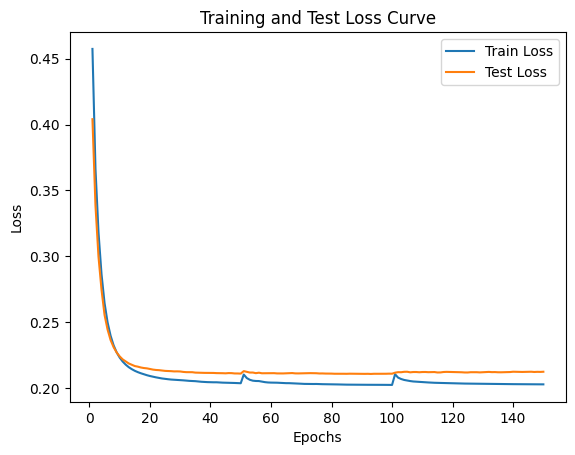

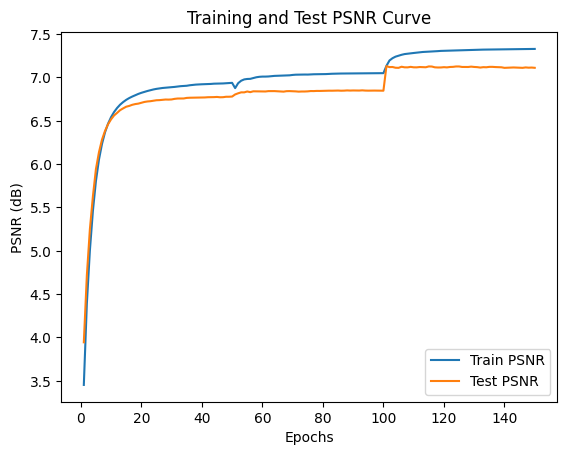

In [ ]:
# Importando os históricos da versão 2 do modelo
hist_0 = pd.read_csv('models/history_v2_0e.csv')
hist_1 = pd.read_csv('models/history_v2_50e.csv')
hist_2 = pd.read_csv('models/history_v2_100e.csv')

# Concatena os históricos em um único
complete_history_v2 = pd.concat([hist_0,hist_1,hist_2])
del hist_0, hist_1, hist_2

# Exibe o histórico de treinamento
plot_hist(complete_history_v2)

In [ ]:
# # Importando os históricos da versão 3 do modelo
# hist_0 = pd.read_csv('models/history_v3_0e.csv')
# hist_1 = pd.read_csv('models/history_v3_50e.csv')
# hist_2 = pd.read_csv('models/history_v3_100e.csv')
# hist_3 = pd.read_csv('models/history_v3_150e.csv')
# hist_4 = pd.read_csv('models/history_v3_200e.csv')

# # Concatena os históricos em um único
# complete_history_v3 = pd.concat([hist_0,hist_1,hist_2,hist_3, hist_4])
# del hist_0,hist_1,hist_2,hist_3, hist_4

# # Exibe o histórico de treinamento
# plot_hist(complete_history_v3)